<a href="https://colab.research.google.com/github/dani-lbnl/mudit/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import packages

In [1]:
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 39 not upgraded.
Need to get 95.3 MB of archives.
After this operation, 327 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 97.0.4692.71-0ubuntu0.18.04.1 [1,142 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 97.0.4692.71-0ubuntu0.18.0

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import Select
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import gensim
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pprint

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_driver():
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  options.add_argument("--disable-infobars")
  # open it, go to a website, and get results
  wd = webdriver.Chrome('chromedriver',options=options)
  return wd

### import and process data from pubs.xlsx

In [3]:
def preprocess_lda(data):
  stop_words = stopwords.words('english')

  def remove_stopwords(texts):
      return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  data_words_nostops = remove_stopwords(data)

  # Create Dictionary 
  id2word = corpora.Dictionary(data_words_nostops)  
  # Create Corpus 
  texts = data_words_nostops  
  # Term Document Frequency 
  corpus = [id2word.doc2bow(text) for text in texts]  

  words = []
  for word in texts:
    words.extend(word)

  return corpus, id2word, words

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
df = pd.read_table('/content/drive/MyDrive/LBNL/Pubs.xls')
abstracts = list(df[~df['Abstract'].isna()]['Abstract'])

corpus_abs, id2word_abs, words_abs = preprocess_lda(abstracts)

### Word2Vec model for something

In [6]:
from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('drive/MyDrive/LBNL/GoogleNews-vectors-negative300.bin', binary=True)
# Access vectors for specific words with a keyed lookup:
vector = model['easy']
vector.shape

(300,)

### using similarity for something

In [7]:
def get_sim(num_topics):

  # create lda model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                            id2word=id2word_abs,
                                            num_topics=num_topics, 
                                            random_state=100,
                                            update_every=1,
                                            #  chunksize=100,
                                            passes=30,
                                            alpha='auto',
                                            per_word_topics=True)

  # initialise similarity list 
  similarity_list = []

  for i in range(num_topics):
    terms_1 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(i)]
    for j in range(i,num_topics):
      terms_2 = [id2word_abs[term[0]] for term in lda_model.get_topic_terms(j)]
      cs = 0
      count = 0
      # print(terms_1, terms_2)
      for val1 in terms_1:
        for val2 in terms_2:
          # print(val1,val2)
          if(val1 in model and val2 in model):
            count += 1
            cs += cosine_similarity(model[[val1]],model[[val2]])[0][0]
      cs = cs/count
      similarity_list.append(cs)
      # print(count)

  return np.array(similarity_list).mean()

x = range(5,50,5)
topic_sim_num = []

for i in x:
  a = get_sim(i)
  print(a)
  topic_sim_num.append(a)

0.14347996536696642
0.13312328573472967
0.12825988814873626
0.1234891007338355
0.12221290234738287
0.12174679965007548
0.12469949845868056
0.11900004197656525
0.11862458477890714


Text(0, 0.5, 'Topic similarity (Cosine)')

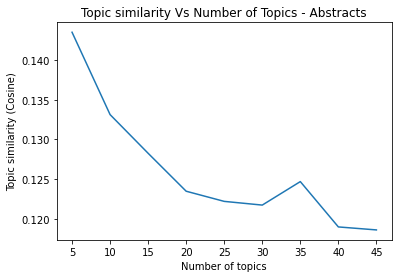

In [8]:
plt.plot(x,topic_sim_num)
plt.title("Topic similarity Vs Number of Topics - Abstracts")
plt.xlabel("Number of topics")
plt.ylabel("Topic similarity (Cosine)")

#### Iteration 1 - on just abstract

In [ ]:
lda_model_abs = gensim.models.ldamodel.LdaModel(corpus=corpus_abs,
                                           id2word=id2word_abs,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
for i in range(25):
  terms = lda_model_abs.get_topic_terms(i)
  print([id2word_abs[term[0]] for term in terms])

['scaffolds', 'ash', 'conversion', 'fuel', 'char', 'mechanical', 'properties', 'formation', 'new', 'fuels']
['sup', 'phase', 'ray', 'eruption', 'using', 'rate', 'plant', 'samples', 'pumice', 'may']
['bone', 'water', 'starch', 'collagen', 'mass', 'hydraulic', 'bark', 'flowers', 'xylem', 'ray']
['ray', 'ct', 'high', 'study', 'tomography', 'three', 'cement', 'fiber', 'cracks', 'evolution']
['vessel', 'flow', 'xylem', 'vessels', 'water', 'transport', 'connections', 'roots', 'dm', 'sap']
['flow', 'water', 'hydraulic', 'sup', 'root', 'function', 'matrix', 'properties', 'tissue', 'conductivity']
['sup', 'inf', 'columns', 'nb', 'calcite', 'fe', 'zr', 'solutions', 'performance', 'experiments']
['inf', 'rates', 'surface', 'carbonate', 'data', 'ray', 'experiments', 'wall', 'based', 'model']
['bone', 'scales', 'collagen', 'fracture', 'electrode', 'structural', 'ray', 'changes', 'structure', 'resistance']
['inf', 'sup', 'leaf', 'high', 'xylem', 'ias', 'water', 'pore', 'hydraulic', 'conductivity']
[

#### Iteration 2 - on combined title and abstract

In [9]:
# set all nulls to blanks - not sure of the reason?

# for title
indices = df['Title'].isna()
df.loc[indices,'Title'] = ""

# for abstract
indices = df['Abstract'].isna()
df.loc[indices,'Abstract'] = ""

# combined - title + abstract
df['Combined'] = df['Title'] + " " + df['Abstract']
combined = list(df['Combined'])

In [10]:
# lda on combined data (title + abstract)

corpus_comb, id2word_comb, words_comb = preprocess_lda(combined)

lda_model_comb = gensim.models.ldamodel.LdaModel(corpus=corpus_comb,
                                           id2word=id2word_comb,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                          #  chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
lda_model_comb.get_topic_terms(0)

[(818, 0.026201194),
 (1051, 0.020536669),
 (387, 0.012013237),
 (6, 0.011775383),
 (381, 0.010277762),
 (8, 0.009944912),
 (380, 0.009155232),
 (1063, 0.008562414),
 (1056, 0.0084966),
 (759, 0.008154762)]

In [22]:
# Print the Keyword in the 10 topics
lda_model_comb.print_topics()
# doc_lda = lda_model_comb[corpus_comb]

[(8,
  '0.016*"magma" + 0.010*"host" + 0.010*"mixing" + 0.009*"data" + 0.008*"dike" + 0.008*"phase" + 0.007*"genes" + 0.007*"latent" + 0.006*"inoculated" + 0.006*"enclaves"'),
 (21,
  '0.019*"bone" + 0.012*"sup" + 0.009*"mass" + 0.009*"mechanical" + 0.008*"trabecular" + 0.007*"tgf" + 0.007*"effects" + 0.006*"properties" + 0.006*"multilayer" + 0.006*"columns"'),
 (6,
  '0.020*"image" + 0.013*"analysis" + 0.012*"area" + 0.011*"using" + 0.011*"algorithm" + 0.009*"data" + 0.009*"algorithms" + 0.008*"study" + 0.008*"estimates" + 0.008*"parallel"'),
 (14,
  '0.010*"crystallization" + 0.009*"pressure" + 0.009*"flowers" + 0.007*"high" + 0.007*"deformation" + 0.007*"stress" + 0.006*"water" + 0.006*"fluid" + 0.006*"measurements" + 0.006*"preferred"'),
 (22,
  '0.035*"bone" + 0.016*"fracture" + 0.012*"mode" + 0.012*"cortical" + 0.010*"mechanical" + 0.010*"materials" + 0.010*"toughness" + 0.007*"osteogenesis" + 0.007*"imperfecta" + 0.006*"collagen"'),
 (5,
  '0.015*"textile" + 0.011*"data" + 0.011

In [12]:
# print words 

for i in range(25):
  terms = lda_model_comb.get_topic_terms(i)
  print(terms)
  print([id2word_comb[term[0]] for term in terms])

[(818, 0.026201194), (1051, 0.020536669), (387, 0.012013237), (6, 0.011775383), (381, 0.010277762), (8, 0.009944912), (380, 0.009155232), (1063, 0.008562414), (1056, 0.0084966), (759, 0.008154762)]
['water', 'transport', 'scale', 'ray', 'porous', 'tomography', 'pore', 'layers', 'gas', 'diffusion']
[(1532, 0.023579532), (1539, 0.012242351), (1533, 0.011625821), (1518, 0.011477373), (8, 0.009666413), (6, 0.00934782), (2013, 0.00870805), (81, 0.0082029905), (1526, 0.0068011833), (818, 0.0062763696)]
['vessel', 'xylem', 'vessels', 'plant', 'tomography', 'ray', 'connections', 'using', 'species', 'water']
[(1285, 0.019892821), (16, 0.019068293), (846, 0.012227114), (1600, 0.010997903), (6063, 0.008838108), (5644, 0.008160308), (380, 0.008160143), (1243, 0.008160037), (391, 0.0075597716), (1525, 0.0075135436)]
['scaffolds', 'bone', 'inf', 'glass', 'nb', 'zr', 'pore', 'bioactive', 'structures', 'repair']
[(564, 0.0128484275), (571, 0.009710316), (44, 0.008574137), (466, 0.008295946), (324, 0.0

#### Analyzing LDA model results

In [24]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 22.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=6873a3ba92a7ba60e4996468572e5d1c6c590f82a787852a7f5ca7c299650255
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [30]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(25))

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_comb, corpus_comb, id2word_comb)


# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_comb, corpus_comb, id2word_comb)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(25) +'.html')
# LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [31]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.146917 -0.023422       1        1  7.937058
20    -0.010170  0.073208       2        1  7.659155
24    -0.083795  0.125480       3        1  7.315986
0     -0.006039  0.158535       4        1  6.670983
1      0.087392  0.064251       5        1  5.704871
17    -0.060092  0.021422       6        1  5.405026
4      0.092302  0.048521       7        1  5.304636
9      0.196777  0.016308       8        1  5.226338
7      0.010341  0.046625       9        1  4.848723
15    -0.002268  0.056168      10        1  4.436738
13    -0.037134  0.107324      11        1  3.942787
23    -0.061464  0.043770      12        1  3.483485
19    -0.017505  0.038863      13        1  3.457107
2     -0.060885 -0.047164      14        1  3.207339
3     -0.018355 -0.059739      15        1  3.154873
18     0.161532 -0.010322      16        1  2.892435
12    -0.077530 -0.077366      17        1  2.788697
5     -0.007453 -0.061033      18        1  2.580402
11     0.034203 -0.043732      19        1  2.559501
6     -0.008888 -0.035950      20        1  2.252457
16    -0.025861  0.022513      21        1  2.131990
14     0.097009 -0.050954      22        1  1.975144
21    -0.060297 -0.109739      23        1  1.961261
22    -0.110557 -0.133506      24        1  1.577281
8      0.115653 -0.170060      25        1  1.525724, topic_info=          Term        Freq       Total Category  logprob  loglift
16        bone  215.000000  215.000000  Default  30.0000  30.0000
3515   lithium   96.000000   96.000000  Default  29.0000  29.0000
846        inf  189.000000  189.000000  Default  28.0000  28.0000
48    fracture   98.000000   98.000000  Default  27.0000  27.0000
1532    vessel   56.000000   56.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1519    plants    2.797069   29.458963  Topic25  -5.3282   1.8283
382     pumice    2.797180   44.169246  Topic25  -5.3281   1.4233
133        one    2.605813   42.019058  Topic25  -5.3990   1.4023
739   analysis    2.229593   91.034137  Topic25  -5.5549   0.4733
2938    leaves    2.104820   14.333304  Topic25  -5.6125   2.2643

[1629 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2178     16  0.739558     ablator
4940      2  0.884344   absorbent
5049     15  0.726292   absorbers
1858      1  0.118261  absorption
1858      2  0.709569  absorption
...     ...       ...         ...
715      14  0.284804          μm
715      17  0.040686          μm
715      18  0.040686          μm
715      19  0.081373          μm
715      20  0.040686          μm

[4497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 21, 25, 1, 2, 18, 5, 10, 8, 16, 14, 24, 20, 3, 4, 19, 13, 6, 12, 7, 17, 15, 22, 23, 9])